<a href="https://colab.research.google.com/github/ViktorJOlah/Neuro_ANN/blob/main/top%20layer%20encoders/VSD_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this is for testing purposes, for getting the most out of GPU

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=445626e80ec6f19c5870752d7825fe30a6d1380573819a7604e8d39a2544b39d
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.2 GB  | Proc size: 96.0 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB
Mounted at /content/drive


In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

In [ ]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LocallyConnected1D

from keras.models import Sequential
from tensorflow.keras import regularizers



import keras

import tensorflow as tf

import random

import matplotlib.pyplot as plt
import gc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [ ]:
params = {
    "batch_size": 64,
    "epochs": 1,
    "lr": 0.0010000,
    "time_steps": 1024,
    "rec_length": 20000
}


TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()
steps_per_epoch = 2000

In [ ]:
data = np.load('/content/drive/My Drive/DNN/ANN_revision/VSD/vm.npy')
mean1 = np.mean(data)
sd1 = np.std(data)
data = (data-mean1)/sd1

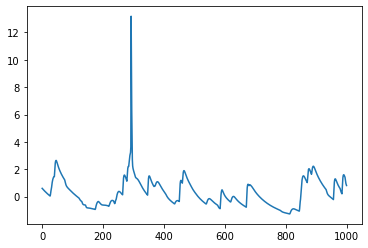

In [ ]:
plt.plot(data[3000:4000])

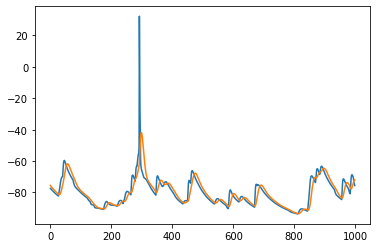

In [ ]:
from scipy import signal
sos = signal.cheby2(2, 10, 3000, 'lp', fs=100000, output='sos')
sos = signal.butter(2, 15, 'lp', fs=500, output='sos')
filtered = signal.sosfilt(sos, data)
plt.plot(data[3000:4000])
plt.plot(filtered[3000:4000])

In [ ]:
np.save('/content/drive/My Drive/DNN/ANN_revision/VSD/vm_filtered.npy',filtered)

In [ ]:
filtered = np.load('/content/drive/My Drive/DNN/ANN_revision/VSD/vm_filtered.npy')
filtered = (filtered-mean1)/sd1

In [ ]:
x_vm_dim0 = data.shape[0]-TIME_STEPS-10

rand_x_train = random.sample(range(x_vm_dim0), int(x_vm_dim0*0.9))
rand_x_test = np.setdiff1d(range(x_vm_dim0), rand_x_train)

In [ ]:

def gen1(df_vm, df_gcamp, rand_vec, TIME_STEPS, BATCH_SIZE):
    dim_0 = df_vm.shape[0] - TIME_STEPS
    x = np.zeros((BATCH_SIZE, 1, TIME_STEPS))
    y = np.zeros((BATCH_SIZE, TIME_STEPS))
    try:
        place = int(len(rand_vec)*random.random())
        randvec = rand_vec[place:place+BATCH_SIZE]
        for i in range(BATCH_SIZE):
            x[i] = np.reshape(df_vm[randvec[i]:TIME_STEPS+randvec[i]], [1,1024])
            y[i] = df_gcamp[randvec[i]:TIME_STEPS+randvec[i]]
    except:
        for i in range(BATCH_SIZE):
            x[i] = np.reshape(df_vm[:TIME_STEPS], [1,1024])
            y[i] = np.reshape(df_gcamp[:TIME_STEPS], [1,1024])

    yield x, y





x_train_counter = tf.data.Dataset.from_generator(gen1, args=[data, filtered, rand_x_train, TIME_STEPS, BATCH_SIZE], output_types=(tf.float16, tf.float16), output_shapes = ((64,1,1024), (64,1024)) ).repeat().prefetch(tf.data.experimental.AUTOTUNE)
x_test_counter = tf.data.Dataset.from_generator(gen1, args=[data, filtered, rand_x_test, TIME_STEPS, BATCH_SIZE], output_types=(tf.float16, tf.float16), output_shapes = ((64,1,1024), (64,1024)) ).repeat(count=500).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
x1, y1 = next(gen1(data, filtered, rand_x_train, TIME_STEPS, BATCH_SIZE))

In [ ]:
x1.shape

(64, 1, 1024)

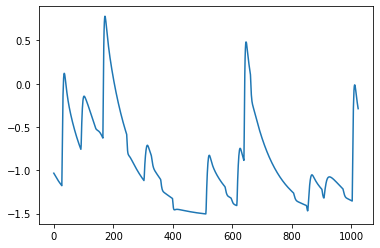

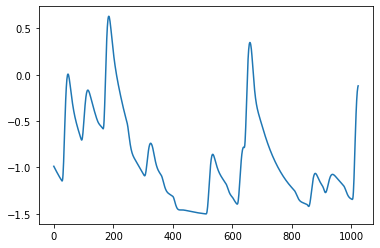

In [ ]:
plt.plot(x1[0][0])
plt.show() 
plt.plot(y1[0])

In [ ]:
def create_model():

    encoder_input = keras.Input(shape=(1,1024))
    x = tf.keras.layers.LSTM(512, return_sequences=True)(encoder_input)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    #x = tf.keras.layers.RepeatVector(10)(x)
    x = tf.keras.layers.LSTM(512, return_sequences=True)(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1024, activation="selu"))(x)
    encoder_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=False))(x)

    encoder = keras.Model(encoder_input, encoder_output, name="encoder")

    encoder.compile(loss='mse', optimizer='Nadam')
    return encoder


model = create_model()
model.summary()

#model = tf.keras.models.load_model('/content/drive/My Drive/DNN/ANN_revision/VSC/weights.378-0.003432-gcamp_deconvolution')

filepath = "weights.{epoch:02d}-{loss:.6f}-gcamp_deconvolution"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                    patience=50, min_delta=0.0001)
    
mcp = ModelCheckpoint(f"/content/drive/My Drive/DNN/ANN_revision/VSC/{filepath}", monitor='val_loss', verbose=1,
                        save_best_only=True, save_weights_only=False, mode='min', period=1)

# Not used here. But leaving it here as a reminder for future
r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, 
                                verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    
history = model.fit(x_train_counter, epochs=50000, steps_per_epoch = 5000, verbose=1, batch_size=64,
                    shuffle=False, validation_data=x_test_counter, validation_steps=400, use_multiprocessing=False, callbacks=[es, mcp, r_lr_plat])


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 1024)]         0         
                                                                 
 lstm_14 (LSTM)              (None, 1, 512)            3147776   
                                                                 
 lstm_15 (LSTM)              (None, 1, 256)            787456    
                                                                 
 lstm_16 (LSTM)              (None, 1, 512)            1574912   
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 1024)          525312    
 tributed)                                                       
                                                                 
 lambda_4 (Lambda)           (None, 1024)              0         
                                                           

Epoch 1/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0716
Epoch 1: val_loss improved from inf to 0.02436, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.01-0.071551-gcamp_deconvolution


5000/5000 [==============================] - 97s 19ms/step - loss: 0.0716 - val_loss: 0.0244 - lr: 0.0010
Epoch 2/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0186
Epoch 2: val_loss improved from 0.02436 to 0.01385, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.02-0.018624-gcamp_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0186 - val_loss: 0.0139 - lr: 0.0010
Epoch 3/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0123
Epoch 3: val_loss improved from 0.01385 to 0.01072, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.03-0.012271-gcamp_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0123 - val_loss: 0.0107 - lr: 0.0010
Epoch 4/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 4: val_loss improved from 0.01072 to 0.01026, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.04-0.010042-gcamp_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0100 - val_loss: 0.0103 - lr: 0.0010
Epoch 5/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0088
Epoch 5: val_loss improved from 0.01026 to 0.00729, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.05-0.008794-gcamp_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0088 - val_loss: 0.0073 - lr: 0.0010
Epoch 6/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 6: val_loss improved from 0.00729 to 0.00671, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.06-0.007132-gcamp_deconvolution


5000/5000 [==============================] - 56s 11ms/step - loss: 0.0071 - val_loss: 0.0067 - lr: 0.0010
Epoch 7/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 7: val_loss did not improve from 0.00671
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0064 - val_loss: 0.0087 - lr: 0.0010
Epoch 8/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0059
Epoch 8: val_loss improved from 0.00671 to 0.00588, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.08-0.005914-gcamp_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0059 - val_loss: 0.0059 - lr: 0.0010
Epoch 9/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 9: val_loss improved from 0.00588 to 0.00517, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.09-0.005563-gcamp_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0056 - val_loss: 0.0052 - lr: 0.0010
Epoch 10/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 10: val_loss improved from 0.00517 to 0.00516, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.10-0.005349-gcamp_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0053 - val_loss: 0.0052 - lr: 0.0010
Epoch 11/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 11: val_loss improved from 0.00516 to 0.00474, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.11-0.005088-gcamp_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0051 - val_loss: 0.0047 - lr: 0.0010
Epoch 12/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 12: val_loss did not improve from 0.00474
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0053 - val_loss: 0.0062 - lr: 0.0010
Epoch 13/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 13: val_loss did not improve from 0.00474
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0047 - val_loss: 0.0052 - lr: 0.0010
Epoch 14/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 14: val_loss improved from 0.00474 to 0.00446, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.14-0.004522-gcamp_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0045 - val_loss: 0.0045 - lr: 0.0010
Epoch 15/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 15: val_loss improved from 0.00446 to 0.00405, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.15-0.004389-gcamp_deconvolution


5000/5000 [==============================] - 58s 12ms/step - loss: 0.0044 - val_loss: 0.0040 - lr: 0.0010
Epoch 16/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 16: val_loss did not improve from 0.00405
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0042 - val_loss: 0.0042 - lr: 0.0010
Epoch 17/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 17: val_loss improved from 0.00405 to 0.00396, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.17-0.004137-gcamp_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0041 - val_loss: 0.0040 - lr: 0.0010
Epoch 18/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 18: val_loss did not improve from 0.00396
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0041 - val_loss: 0.0054 - lr: 0.0010
Epoch 19/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0040
Epoch 19: val_loss did not improve from 0.00396
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0040 - val_loss: 0.0040 - lr: 0.0010
Epoch 20/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 20: val_loss did not improve from 0.00396
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0039 - val_loss: 0.0041 - lr: 0.0010
Epoch 21/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 21: val_loss improved from 0.00396 to 0.00365, saving model to /content/drive/My Drive/DNN/ANN_re

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0044 - val_loss: 0.0037 - lr: 0.0010
Epoch 22/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0038
Epoch 22: val_loss did not improve from 0.00365
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0038 - val_loss: 0.0038 - lr: 0.0010
Epoch 23/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 23: val_loss did not improve from 0.00365
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0038 - val_loss: 0.0040 - lr: 0.0010
Epoch 24/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 24: val_loss improved from 0.00365 to 0.00357, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.24-0.003726-gcamp_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0037 - val_loss: 0.0036 - lr: 0.0010
Epoch 25/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 25: val_loss did not improve from 0.00357
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0037 - val_loss: 0.0055 - lr: 0.0010
Epoch 26/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 26: val_loss did not improve from 0.00357
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0037 - val_loss: 0.0052 - lr: 0.0010
Epoch 27/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 27: val_loss did not improve from 0.00357
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0036 - val_loss: 0.0037 - lr: 0.0010
Epoch 28/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 28: val_loss did not improve from 0.00357
5000/5000 [==============================] - 44s 9ms/st

5000/5000 [==============================] - 53s 11ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 0.0010
Epoch 31/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 31: val_loss did not improve from 0.00348
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0035 - val_loss: 0.0036 - lr: 0.0010
Epoch 32/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0040
Epoch 32: val_loss did not improve from 0.00348
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0040 - val_loss: 0.0037 - lr: 0.0010
Epoch 33/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 33: val_loss did not improve from 0.00348
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0039 - val_loss: 0.0036 - lr: 0.0010
Epoch 34/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 34: val_loss improved from 0.00348 to 0.00331, saving model to /content/drive/My Drive/DNN/ANN_re

5000/5000 [==============================] - 56s 11ms/step - loss: 0.0035 - val_loss: 0.0033 - lr: 0.0010
Epoch 35/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 35: val_loss did not improve from 0.00331
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0034 - val_loss: 0.0036 - lr: 0.0010
Epoch 36/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 36: val_loss did not improve from 0.00331
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0034 - val_loss: 0.0034 - lr: 0.0010
Epoch 37/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 37: val_loss did not improve from 0.00331
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0034 - val_loss: 0.0033 - lr: 0.0010
Epoch 38/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0034
Epoch 38: val_loss did not improve from 0.00331
5000/5000 [==============================] - 43s 9ms/st

5000/5000 [==============================] - 55s 11ms/step - loss: 0.0033 - val_loss: 0.0031 - lr: 0.0010
Epoch 40/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 40: val_loss did not improve from 0.00308
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0033 - val_loss: 0.0032 - lr: 0.0010
Epoch 41/50000
4994/5000 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 41: val_loss did not improve from 0.00308
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0034 - val_loss: 0.0049 - lr: 0.0010
Epoch 42/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0033
Epoch 42: val_loss did not improve from 0.00308
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0033 - val_loss: 0.0032 - lr: 0.0010
Epoch 43/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0033
Epoch 43: val_loss did not improve from 0.00308
5000/5000 [==============================] - 44s 9ms/st

5000/5000 [==============================] - 55s 11ms/step - loss: 0.0033 - val_loss: 0.0029 - lr: 0.0010
Epoch 54/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 54: val_loss did not improve from 0.00287
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0032 - val_loss: 0.0032 - lr: 0.0010
Epoch 55/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 55: val_loss did not improve from 0.00287
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0032 - val_loss: 0.0032 - lr: 0.0010
Epoch 56/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 56: val_loss did not improve from 0.00287
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0032 - val_loss: 0.0030 - lr: 0.0010
Epoch 57/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0031
Epoch 57: val_loss did not improve from 0.00287
5000/5000 [==============================] - 46s 9ms/st

5000/5000 [==============================] - 55s 11ms/step - loss: 0.0032 - val_loss: 0.0027 - lr: 0.0010
Epoch 68/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0030
Epoch 68: val_loss did not improve from 0.00270
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0030 - val_loss: 0.0044 - lr: 0.0010
Epoch 69/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0031
Epoch 69: val_loss did not improve from 0.00270
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0031 - val_loss: 0.0047 - lr: 0.0010
Epoch 70/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0031
Epoch 70: val_loss did not improve from 0.00270
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0031 - val_loss: 0.0029 - lr: 0.0010
Epoch 71/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 71: val_loss did not improve from 0.00270
5000/5000 [==============================] - 44s 9ms/st

5000/5000 [==============================] - 55s 11ms/step - loss: 0.0022 - val_loss: 0.0018 - lr: 5.0000e-04
Epoch 89/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 89: val_loss did not improve from 0.00175
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0019 - val_loss: 0.0018 - lr: 5.0000e-04
Epoch 90/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 90: val_loss did not improve from 0.00175
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0018 - val_loss: 0.0020 - lr: 5.0000e-04
Epoch 91/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 91: val_loss improved from 0.00175 to 0.00174, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.91-0.001814-gcamp_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0018 - val_loss: 0.0017 - lr: 5.0000e-04
Epoch 92/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 92: val_loss did not improve from 0.00174
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0018 - val_loss: 0.0035 - lr: 5.0000e-04
Epoch 93/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 93: val_loss improved from 0.00174 to 0.00163, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.93-0.001795-gcamp_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0018 - val_loss: 0.0016 - lr: 5.0000e-04
Epoch 94/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0018
Epoch 94: val_loss did not improve from 0.00163
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0018 - val_loss: 0.0017 - lr: 5.0000e-04
Epoch 95/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 95: val_loss did not improve from 0.00163
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0018 - val_loss: 0.0018 - lr: 5.0000e-04
Epoch 96/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 96: val_loss did not improve from 0.00163
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0018 - val_loss: 0.0018 - lr: 5.0000e-04
Epoch 97/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 97: val_loss did not improve from 0.00163
5000/5000 [============================

5000/5000 [==============================] - 55s 11ms/step - loss: 0.0017 - val_loss: 0.0016 - lr: 5.0000e-04
Epoch 104/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0017
Epoch 104: val_loss did not improve from 0.00160
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0017 - val_loss: 0.0018 - lr: 5.0000e-04
Epoch 105/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 105: val_loss did not improve from 0.00160
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0017 - val_loss: 0.0031 - lr: 5.0000e-04
Epoch 106/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 106: val_loss did not improve from 0.00160
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0017 - val_loss: 0.0018 - lr: 5.0000e-04
Epoch 107/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0019
Epoch 107: val_loss did not improve from 0.00160
5000/5000 [====================


Epoch 113: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
5000/5000 [==============================] - 55s 11ms/step - loss: 0.0017 - val_loss: 0.0016 - lr: 5.0000e-04
Epoch 114/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 114: val_loss improved from 0.00158 to 0.00148, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.114-0.001324-gcamp_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0013 - val_loss: 0.0015 - lr: 2.5000e-04
Epoch 115/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 115: val_loss improved from 0.00148 to 0.00148, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.115-0.001308-gcamp_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0013 - val_loss: 0.0015 - lr: 2.5000e-04
Epoch 116/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 116: val_loss improved from 0.00148 to 0.00120, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.116-0.001443-gcamp_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0014 - val_loss: 0.0012 - lr: 2.5000e-04
Epoch 117/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 117: val_loss did not improve from 0.00120
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0013 - val_loss: 0.0013 - lr: 2.5000e-04
Epoch 118/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 118: val_loss did not improve from 0.00120
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0013 - val_loss: 0.0012 - lr: 2.5000e-04
Epoch 119/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 119: val_loss did not improve from 0.00120
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0013 - val_loss: 0.0032 - lr: 2.5000e-04
Epoch 120/50000
4994/5000 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 120: val_loss did not improve from 0.00120
5000/5000 [====================

5000/5000 [==============================] - 56s 11ms/step - loss: 0.0013 - val_loss: 0.0012 - lr: 2.5000e-04
Epoch 122/50000
4994/5000 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 122: val_loss did not improve from 0.00118
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0013 - val_loss: 0.0013 - lr: 2.5000e-04
Epoch 123/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 123: val_loss did not improve from 0.00118
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0012 - val_loss: 0.0013 - lr: 2.5000e-04
Epoch 124/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 124: val_loss did not improve from 0.00118
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0012 - val_loss: 0.0014 - lr: 2.5000e-04
Epoch 125/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 125: val_loss did not improve from 0.00118
5000/5000 [====================

5000/5000 [==============================] - 53s 11ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 2.5000e-04
Epoch 129/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 129: val_loss did not improve from 0.00116
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0012 - val_loss: 0.0013 - lr: 2.5000e-04
Epoch 130/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 130: val_loss did not improve from 0.00116
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0012 - val_loss: 0.0013 - lr: 2.5000e-04
Epoch 131/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 131: val_loss did not improve from 0.00116
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0012 - val_loss: 0.0013 - lr: 2.5000e-04
Epoch 132/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 132: val_loss did not improve from 0.00116
5000/5000 [====================

5000/5000 [==============================] - 55s 11ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 2.5000e-04
Epoch 135/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 135: val_loss did not improve from 0.00115
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 2.5000e-04
Epoch 136/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 136: val_loss improved from 0.00115 to 0.00112, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.136-0.001380-gcamp_deconvolution



Epoch 136: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
5000/5000 [==============================] - 53s 11ms/step - loss: 0.0014 - val_loss: 0.0011 - lr: 2.5000e-04
Epoch 137/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 137: val_loss did not improve from 0.00112
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0011 - val_loss: 0.0014 - lr: 1.2500e-04
Epoch 138/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 138: val_loss improved from 0.00112 to 0.00111, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.138-0.001078-gcamp_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 1.2500e-04
Epoch 139/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 139: val_loss improved from 0.00111 to 0.00099, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.139-0.001065-gcamp_deconvolution


5000/5000 [==============================] - 56s 11ms/step - loss: 0.0011 - val_loss: 9.9157e-04 - lr: 1.2500e-04
Epoch 140/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 140: val_loss did not improve from 0.00099
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 1.2500e-04
Epoch 141/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 141: val_loss did not improve from 0.00099
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 1.2500e-04
Epoch 142/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 142: val_loss did not improve from 0.00099
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 1.2500e-04
Epoch 143/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 143: val_loss did not improve from 0.00099
5000/5000 [================

5000/5000 [==============================] - 53s 11ms/step - loss: 0.0011 - val_loss: 9.7880e-04 - lr: 1.2500e-04
Epoch 145/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 145: val_loss did not improve from 0.00098
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 1.2500e-04
Epoch 146/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 146: val_loss did not improve from 0.00098
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 1.2500e-04
Epoch 147/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 147: val_loss did not improve from 0.00098
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 1.2500e-04
Epoch 148/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 148: val_loss did not improve from 0.00098
5000/5000 [================

5000/5000 [==============================] - 57s 11ms/step - loss: 0.0010 - val_loss: 9.0857e-04 - lr: 1.2500e-04
Epoch 158/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 158: val_loss did not improve from 0.00091
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0010 - val_loss: 9.8464e-04 - lr: 1.2500e-04
Epoch 159/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 159: val_loss did not improve from 0.00091

Epoch 159: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0010 - val_loss: 9.7992e-04 - lr: 1.2500e-04
Epoch 160/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 160: val_loss did not improve from 0.00091
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0010 - val_loss: 0.0012 - lr: 6.2500e-05
Epoch 161/50000
4995/5000 [============================>.] - ETA: 0s - los

5000/5000 [==============================] - 55s 11ms/step - loss: 9.7873e-04 - val_loss: 9.0245e-04 - lr: 6.2500e-05
Epoch 163/50000
4998/5000 [============================>.] - ETA: 0s - loss: 9.7635e-04
Epoch 163: val_loss did not improve from 0.00090
5000/5000 [==============================] - 46s 9ms/step - loss: 9.7636e-04 - val_loss: 0.0011 - lr: 6.2500e-05
Epoch 164/50000
4998/5000 [============================>.] - ETA: 0s - loss: 9.6017e-04
Epoch 164: val_loss did not improve from 0.00090
5000/5000 [==============================] - 44s 9ms/step - loss: 9.6060e-04 - val_loss: 0.0011 - lr: 6.2500e-05
Epoch 165/50000
4997/5000 [============================>.] - ETA: 0s - loss: 9.5761e-04
Epoch 165: val_loss did not improve from 0.00090
5000/5000 [==============================] - 45s 9ms/step - loss: 9.5757e-04 - val_loss: 0.0011 - lr: 6.2500e-05
Epoch 166/50000
5000/5000 [==============================] - ETA: 0s - loss: 9.7765e-04
Epoch 166: val_loss did not improve from 0.0

5000/5000 [==============================] - 54s 11ms/step - loss: 9.5195e-04 - val_loss: 8.6690e-04 - lr: 6.2500e-05
Epoch 177/50000
4999/5000 [============================>.] - ETA: 0s - loss: 9.4654e-04
Epoch 177: val_loss did not improve from 0.00087
5000/5000 [==============================] - 44s 9ms/step - loss: 9.4656e-04 - val_loss: 9.4654e-04 - lr: 6.2500e-05
Epoch 178/50000
4998/5000 [============================>.] - ETA: 0s - loss: 9.4764e-04
Epoch 178: val_loss did not improve from 0.00087
5000/5000 [==============================] - 46s 9ms/step - loss: 9.4752e-04 - val_loss: 9.1546e-04 - lr: 6.2500e-05
Epoch 179/50000
4995/5000 [============================>.] - ETA: 0s - loss: 9.5666e-04
Epoch 179: val_loss did not improve from 0.00087
5000/5000 [==============================] - 44s 9ms/step - loss: 9.5673e-04 - val_loss: 0.0012 - lr: 6.2500e-05
Epoch 180/50000
4996/5000 [============================>.] - ETA: 0s - loss: 9.3683e-04
Epoch 180: val_loss did not improve 

5000/5000 [==============================] - 57s 11ms/step - loss: 9.3967e-04 - val_loss: 8.1617e-04 - lr: 6.2500e-05
Epoch 188/50000
4995/5000 [============================>.] - ETA: 0s - loss: 9.3986e-04
Epoch 188: val_loss did not improve from 0.00082
5000/5000 [==============================] - 44s 9ms/step - loss: 9.4016e-04 - val_loss: 8.8405e-04 - lr: 6.2500e-05
Epoch 189/50000
4995/5000 [============================>.] - ETA: 0s - loss: 9.3357e-04
Epoch 189: val_loss did not improve from 0.00082
5000/5000 [==============================] - 45s 9ms/step - loss: 9.3356e-04 - val_loss: 8.2220e-04 - lr: 6.2500e-05
Epoch 190/50000
5000/5000 [==============================] - ETA: 0s - loss: 9.3131e-04
Epoch 190: val_loss improved from 0.00082 to 0.00080, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.190-0.000931-gcamp_deconvolution


5000/5000 [==============================] - 56s 11ms/step - loss: 9.3131e-04 - val_loss: 7.9702e-04 - lr: 6.2500e-05
Epoch 191/50000
4999/5000 [============================>.] - ETA: 0s - loss: 9.3286e-04
Epoch 191: val_loss did not improve from 0.00080
5000/5000 [==============================] - 44s 9ms/step - loss: 9.3284e-04 - val_loss: 8.1359e-04 - lr: 6.2500e-05
Epoch 192/50000
4998/5000 [============================>.] - ETA: 0s - loss: 9.2967e-04
Epoch 192: val_loss did not improve from 0.00080
5000/5000 [==============================] - 45s 9ms/step - loss: 9.2962e-04 - val_loss: 8.6726e-04 - lr: 6.2500e-05
Epoch 193/50000
4994/5000 [============================>.] - ETA: 0s - loss: 9.4203e-04
Epoch 193: val_loss did not improve from 0.00080
5000/5000 [==============================] - 45s 9ms/step - loss: 9.4210e-04 - val_loss: 9.6136e-04 - lr: 6.2500e-05
Epoch 194/50000
4999/5000 [============================>.] - ETA: 0s - loss: 9.6182e-04
Epoch 194: val_loss did not impr

5000/5000 [==============================] - 54s 11ms/step - loss: 8.9271e-04 - val_loss: 7.6434e-04 - lr: 3.1250e-05
Epoch 217/50000
4997/5000 [============================>.] - ETA: 0s - loss: 8.9365e-04
Epoch 217: val_loss did not improve from 0.00076
5000/5000 [==============================] - 45s 9ms/step - loss: 8.9363e-04 - val_loss: 9.6457e-04 - lr: 3.1250e-05
Epoch 218/50000
5000/5000 [==============================] - ETA: 0s - loss: 8.9053e-04
Epoch 218: val_loss did not improve from 0.00076
5000/5000 [==============================] - 44s 9ms/step - loss: 8.9053e-04 - val_loss: 8.1168e-04 - lr: 3.1250e-05
Epoch 219/50000
4997/5000 [============================>.] - ETA: 0s - loss: 8.8831e-04
Epoch 219: val_loss did not improve from 0.00076
5000/5000 [==============================] - 44s 9ms/step - loss: 8.8849e-04 - val_loss: 0.0010 - lr: 3.1250e-05
Epoch 220/50000
4999/5000 [============================>.] - ETA: 0s - loss: 8.8712e-04
Epoch 220: val_loss did not improve 

5000/5000 [==============================] - 56s 11ms/step - loss: 8.7089e-04 - val_loss: 7.1809e-04 - lr: 1.5625e-05
Epoch 254/50000
4997/5000 [============================>.] - ETA: 0s - loss: 8.7065e-04
Epoch 254: val_loss did not improve from 0.00072
5000/5000 [==============================] - 46s 9ms/step - loss: 8.7055e-04 - val_loss: 8.5719e-04 - lr: 1.5625e-05
Epoch 255/50000
4999/5000 [============================>.] - ETA: 0s - loss: 8.7162e-04
Epoch 255: val_loss did not improve from 0.00072
5000/5000 [==============================] - 45s 9ms/step - loss: 8.7163e-04 - val_loss: 8.3048e-04 - lr: 1.5625e-05
Epoch 256/50000
4999/5000 [============================>.] - ETA: 0s - loss: 8.7090e-04
Epoch 256: val_loss did not improve from 0.00072

Epoch 256: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
5000/5000 [==============================] - 44s 9ms/step - loss: 8.7086e-04 - val_loss: 8.7712e-04 - lr: 1.5625e-05
Epoch 257/50000
4999/5000 [==============

5000/5000 [==============================] - 56s 11ms/step - loss: 8.6028e-04 - val_loss: 6.9774e-04 - lr: 7.8125e-06
Epoch 265/50000
4997/5000 [============================>.] - ETA: 0s - loss: 8.6077e-04
Epoch 265: val_loss did not improve from 0.00070
5000/5000 [==============================] - 45s 9ms/step - loss: 8.6073e-04 - val_loss: 8.7534e-04 - lr: 7.8125e-06
Epoch 266/50000
4995/5000 [============================>.] - ETA: 0s - loss: 8.5773e-04
Epoch 266: val_loss did not improve from 0.00070
5000/5000 [==============================] - 45s 9ms/step - loss: 8.5768e-04 - val_loss: 0.0010 - lr: 7.8125e-06
Epoch 266: early stopping


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/DNN/ANN_revision/VSC/weights.264-0.000860-gcamp_deconvolution')

@tf.function
def serve_CNN_LSTM(x):
    return model(x, training=False)

In [ ]:
x_t, y_t = next(gen1(data, filtered, rand_x_train, TIME_STEPS, BATCH_SIZE))


In [ ]:
np.max(x_t)

14.312301308094096

In [ ]:
vmi1 = serve_CNN_LSTM(x_t)

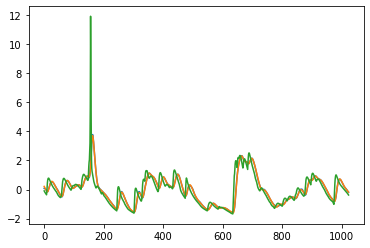

0


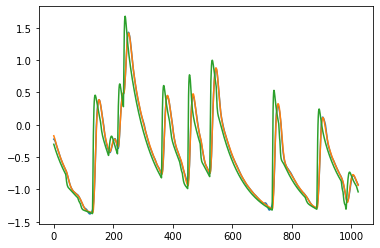

1


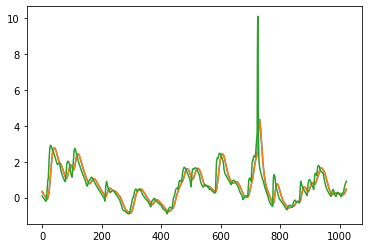

2


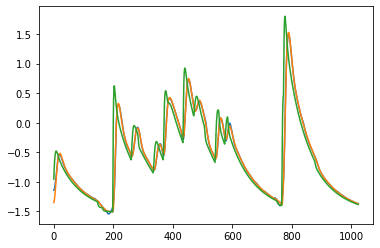

3


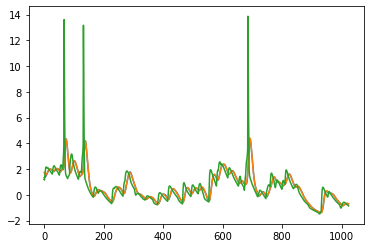

4


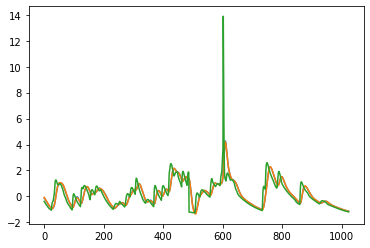

5


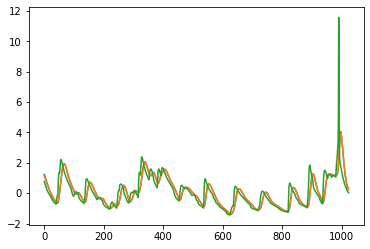

6


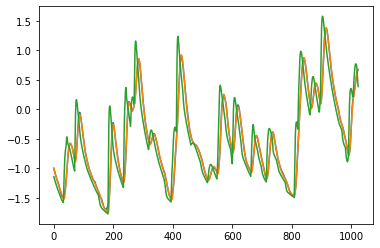

7


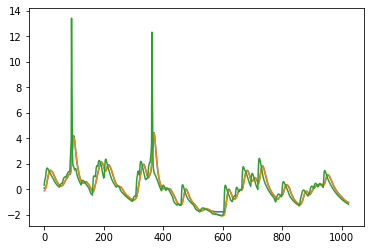

8


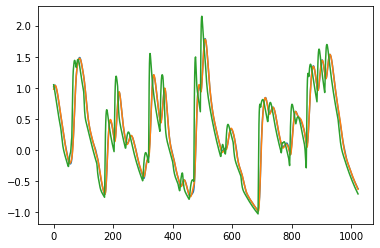

9


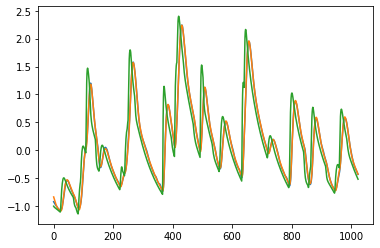

10


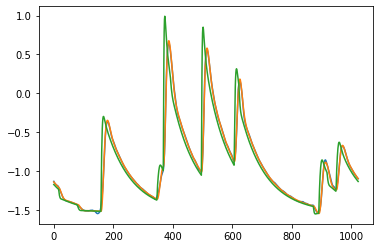

11


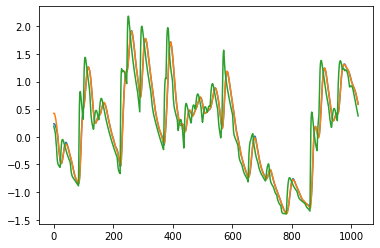

12


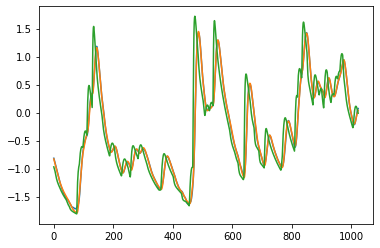

13


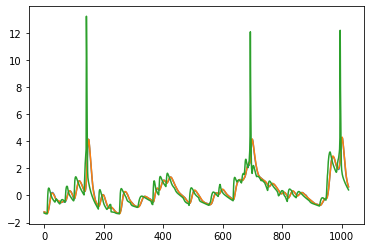

14


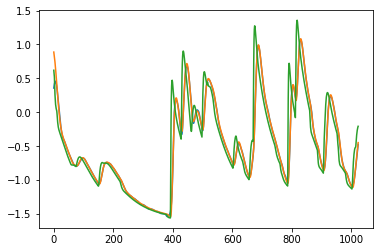

15


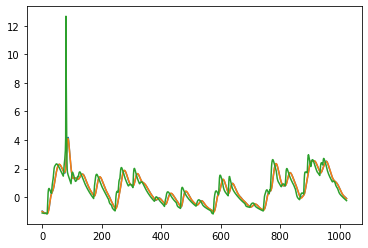

16


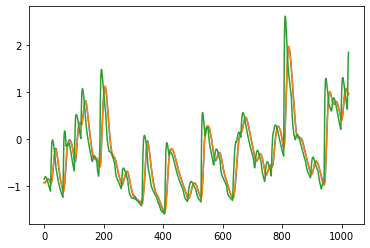

17


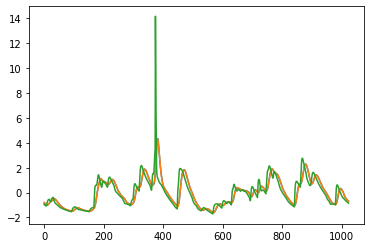

18


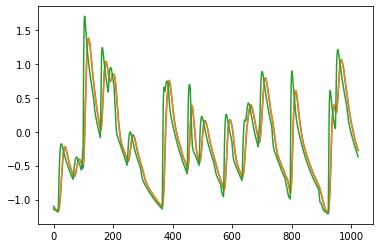

19


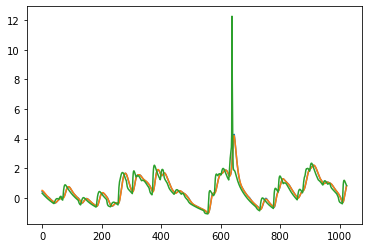

20


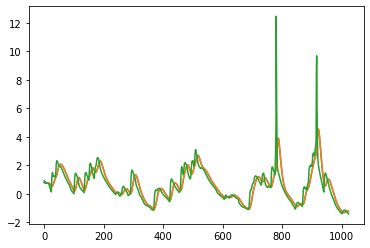

21


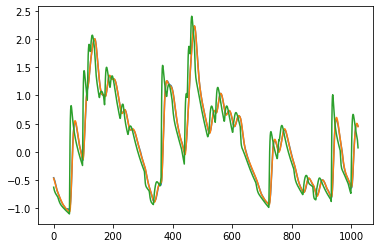

22


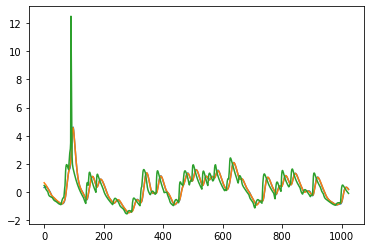

23


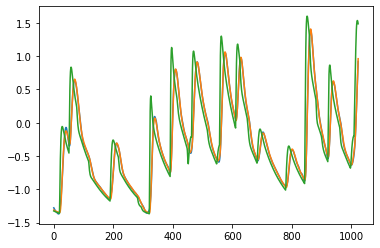

24


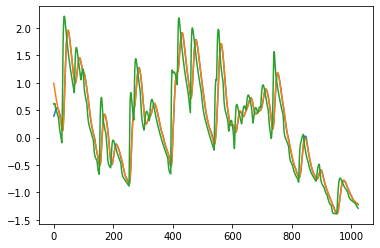

25


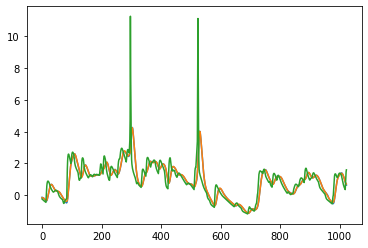

26


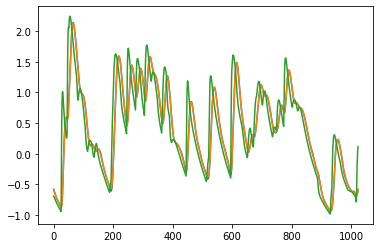

27


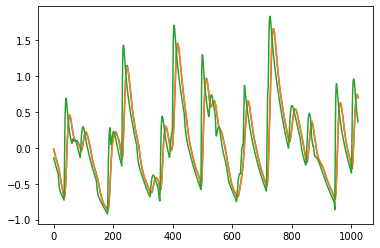

28


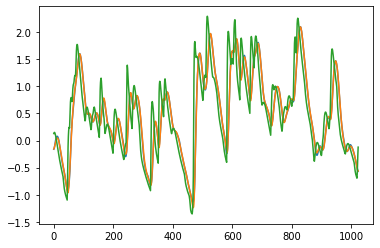

29


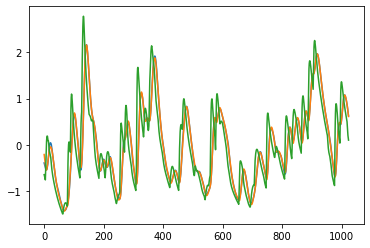

30


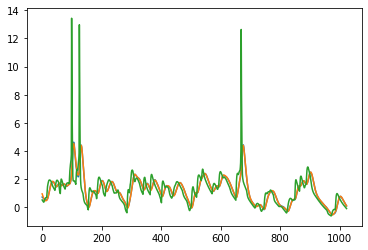

31


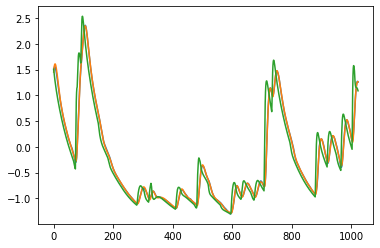

32


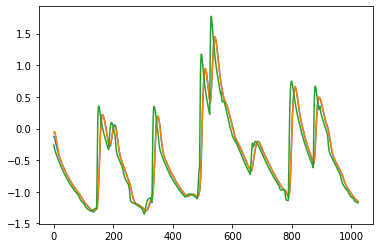

33


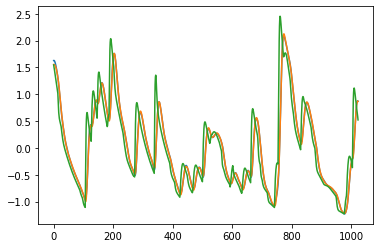

34


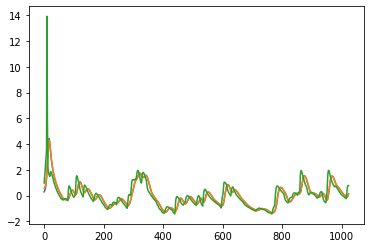

35


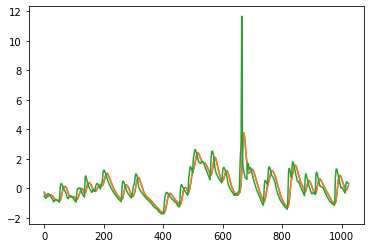

36


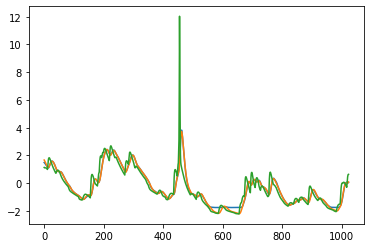

37


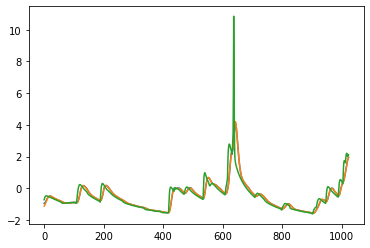

38


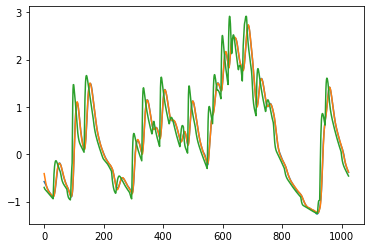

39


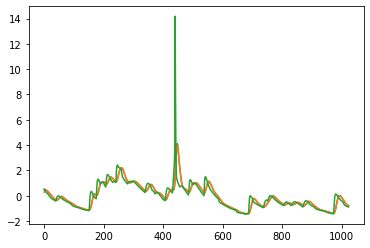

40


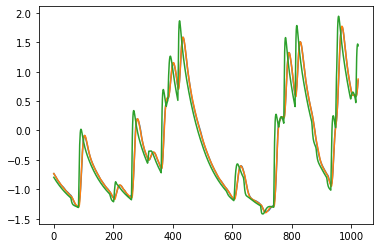

41


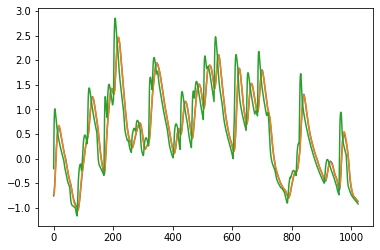

42


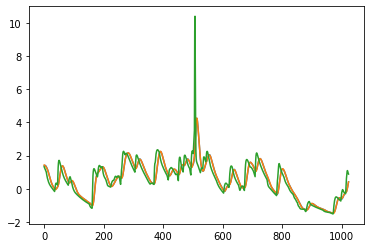

43


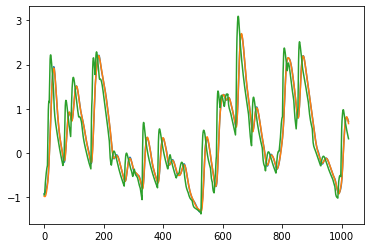

44


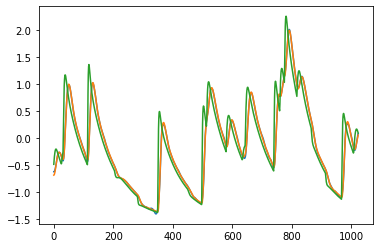

45


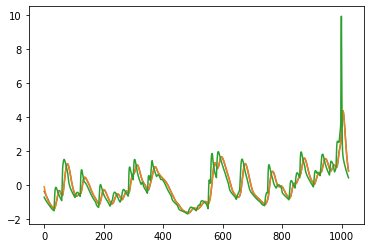

46


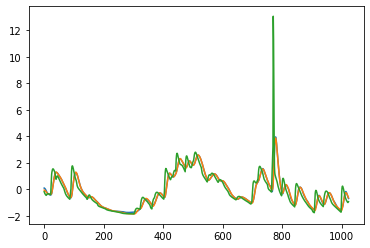

47


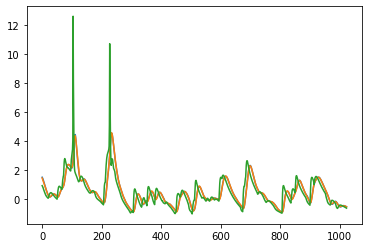

48


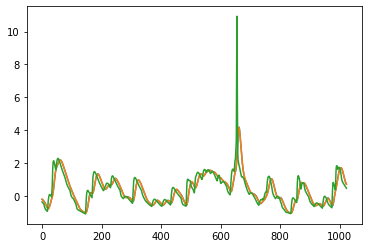

49


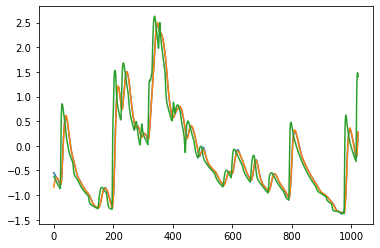

50


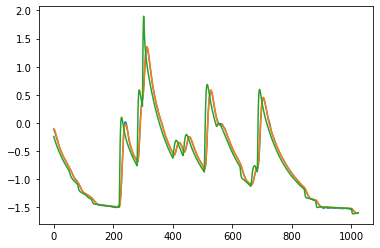

51


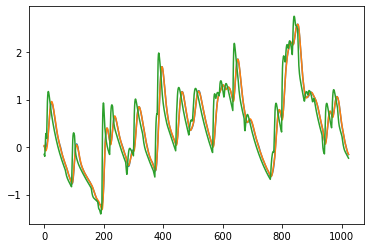

52


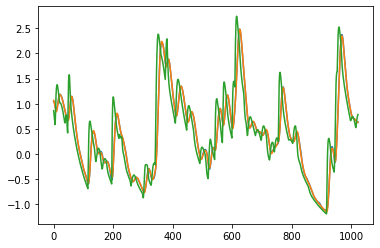

53


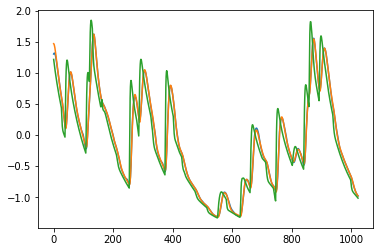

54


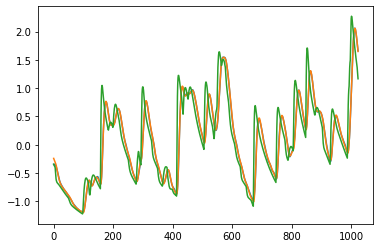

55


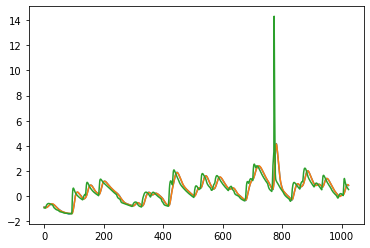

56


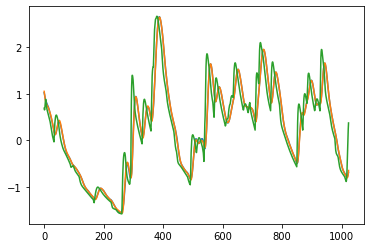

57


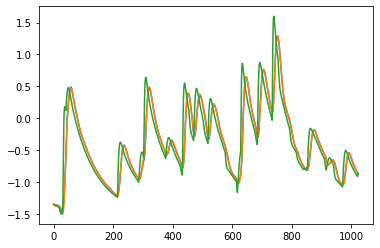

58


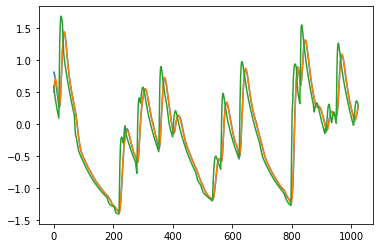

59


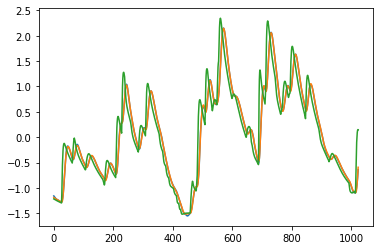

60


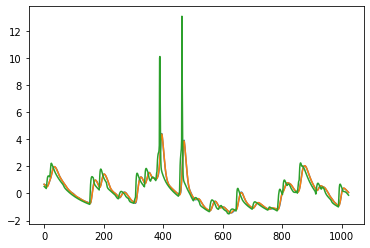

61


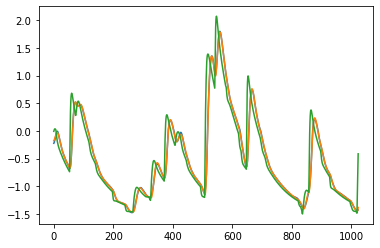

62


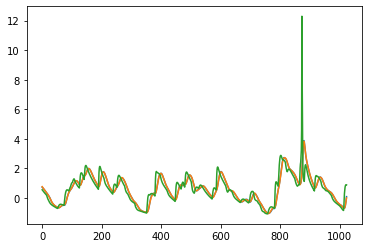

63


In [ ]:
vmi2 = np.asarray(vmi1)
for i in range(64):
    plt.plot(vmi2[i])
    plt.plot(y_t[i])
    plt.plot(x_t[i,0])
    plt.show()
    print(i)

In [ ]:
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/convolution_fit_pred.txt',vmi2.flatten(order='C'))
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/convolution_fit_GT.txt',y_t.flatten(order='C'))

In [ ]:
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/convolution_prediction_pred.txt',vmi2[31])
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/convolution_prediction_GT.txt',y_t[31])
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/convolution_prediction_vm.txt',x_t[31,0])

In [ ]:
#evalute explained variance
for i in range(50):
    mse = np.mean((vmi2[i]-y_t[i])**2)
    var = np.var(y_t[i])
    var_explained = 1-(mse/var)
    if(var>0.01):
        print(var_explained)

0.9991321963241535
0.9991449211990867
0.9996464274500062
0.9985495012657711
0.9986919578166941
0.9989190951700709
0.9992396722469932
0.9987786124583244
0.9977336050299279
0.9994757617378364
0.999482731601734
0.9991700209949139
0.9992420328938123
0.9993373059194933
0.9991433380583153
0.9969280651217101
0.9995453594703226
0.9987565936631252
0.9992123115004717
0.9992033998502518
0.9995060478176658
0.9994674443609867
0.9996777901976263
0.9988475458328145
0.9992002175378984
0.9972875122801725
0.999449825797717
0.9996305171601729
0.9992572929656881
0.9993026545689435
0.9989910158150961
0.9988481361755813
0.9996744388918403
0.9990809982329727
0.9994821007753026
0.9987847274069015
0.99905894950223
0.9933171829048664
0.999292434431738
0.9997124585718028
0.9992469298757125
0.999687744646764
0.9994930386825409
0.9996498637744482
0.999535073990183
0.9994755172773554
0.9991897100177211
0.9988713507492576
0.9992478300229223
0.9994445952518688
